# OrderHeader_PurchasingOrderQuantity

## Import the necessary libraries

In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

pd.options.mode.chained_assignment = None
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from deds_helpers.common_functions import drop_sk_datetime_added_columns as drop_columns, train_model, get_engine, \
    read_data_return_df, plot_predictions, plot_feature_importance, plot_decision_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import torch

## Connecting to the database

In [2]:
engine = get_engine()

Connection to UnitedOutdoors database successful


## Reading in the data

In [3]:
sql_query_orderheader = "SELECT * FROM SalesOrderHeader"
orderheader_df = read_data_return_df(sql_query_orderheader, engine)

orderheader_df.head()

,SALESORDERHEADER_sk,SALESORDERHEADER_SALESORDERDETAIL_SalesOrderID,SALESORDERHEADER_SALESORDERDETAIL_SalesOrderDetailID,SALESORDERHEADER_SALESORDERDETAIL_CarrierTrackingNumber,SALESORDERHEADER_SALESORDERDETAIL_OrderQty,SALESORDERHEADER_SALESORDERDETAIL_ProductID,SALESORDERHEADER_SALESORDERDETAIL_SpecialOfferID,SALESORDERHEADER_SALESORDERDETAIL_UnitPrice,SALESORDERHEADER_SALESORDERDETAIL_UnitPriceDiscount,SALESORDERHEADER_SALESORDERDETAIL_LineTotal,...,SALESORDERHEADER_SALESORDER_CustID,SALESORDERHEADER_SALESORDER_OrderDate,SALESORDERHEADER_SALESORDER_Region,SALESORDERHEADER_SALESORDER_SalesRep,SALESORDERHEADER_SALESORDERITEM_SalesOrderItemID,SALESORDERHEADER_SALESORDERITEM_LineID,SALESORDERHEADER_SALESORDERITEM_ProdID,SALESORDERHEADER_SALESORDERITEM_Quantity,SALESORDERHEADER_SALESORDERITEM_ShipDate,SALESORDERHEADER_datetime_added
0,1,43697.0,353.0,None,1.0,474.0,201.0,3578.27,0.0,3578.27,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,2024-05-26 17:15:53.913
1,2,43697.0,353.0,None,1.0,474.0,201.0,3578.27,0.0,3578.27,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,2024-05-26 17:15:53.913
2,3,43702.0,358.0,None,1.0,480.0,201.0,3578.27,0.0,3578.27,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,2024-05-26 17:15:53.913
3,4,43702.0,358.0,None,1.0,480.0,201.0,3578.27,0.0,3578.27,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,2024-05-26 17:15:53.913
4,5,43703.0,359.0,None,1.0,474.0,201.0,3578.27,0.0,3578.27,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,2024-05-26 17:15:53.913


## Data Cleaning

In [4]:
# dropping unnecessary columns
columns_to_keep = ['SALESORDERHEADER_sk', 'SALESORDERHEADER_SALESORDERDETAIL_OrderQty', 'SALESORDERHEADER_SALESORDERDETAIL_ProductID', 'SALESORDERHEADER_SALESORDERDETAIL_SpecialOfferID', 'SALESORDERHEADER_SALESORDERDETAIL_UnitPrice', 'SALESORDERHEADER_SALESORDERDETAIL_UnitPriceDiscount', 'SALESORDERHEADER_SALESORDERHEADER_TerritoryID']

combined_df = orderheader_df[columns_to_keep]

In [5]:
# fixing null values
drop_columns(combined_df)

In [6]:
# converting types
combined_df['SALESORDERHEADER_SALESORDERDETAIL_OrderQty'] = combined_df['SALESORDERHEADER_SALESORDERDETAIL_OrderQty'].astype('int')

combined_df['SALESORDERHEADER_SALESORDERDETAIL_ProductID'] = combined_df['SALESORDERHEADER_SALESORDERDETAIL_ProductID'].astype('int').astype('category').cat.codes
combined_df['SALESORDERHEADER_SALESORDERDETAIL_SpecialOfferID'] = combined_df['SALESORDERHEADER_SALESORDERDETAIL_SpecialOfferID'].astype('int').astype('category').cat.codes
combined_df['SALESORDERHEADER_SALESORDERHEADER_TerritoryID'] = combined_df['SALESORDERHEADER_SALESORDERHEADER_TerritoryID'].astype('int').astype('category').cat.codes

In [7]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67773 entries, 0 to 67772
Data columns (total 6 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   SALESORDERHEADER_SALESORDERDETAIL_OrderQty           67773 non-null  int32  
 1   SALESORDERHEADER_SALESORDERDETAIL_ProductID          67773 non-null  int8   
 2   SALESORDERHEADER_SALESORDERDETAIL_SpecialOfferID     67773 non-null  int8   
 3   SALESORDERHEADER_SALESORDERDETAIL_UnitPrice          67773 non-null  float64
 4   SALESORDERHEADER_SALESORDERDETAIL_UnitPriceDiscount  67773 non-null  float64
 5   SALESORDERHEADER_SALESORDERHEADER_TerritoryID        67773 non-null  int8   
dtypes: float64(2), int32(1), int8(3)
memory usage: 1.5 MB


## Data Analysis

### Splitting the data

In [8]:
# splitting the data
X = combined_df.drop(columns=['SALESORDERHEADER_SALESORDERDETAIL_OrderQty'])
y = combined_df['SALESORDERHEADER_SALESORDERDETAIL_OrderQty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [9]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# fitting the model
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [11]:
# predicting the values
lr_y_pred = lr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [12]:
# calculating the metrics
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Mean Squared Error: {lr_mse}')
print(f'R2 Score: {lr_r2}')

Mean Squared Error: 4.771132635973448e-30
R2 Score: 1.0


C:\Users\Tjorn\PycharmProjects\United-Outdoors\visualization\static\training\prediction\OrderHeader_PurchasingOrderQuantity\lr_scatter.png


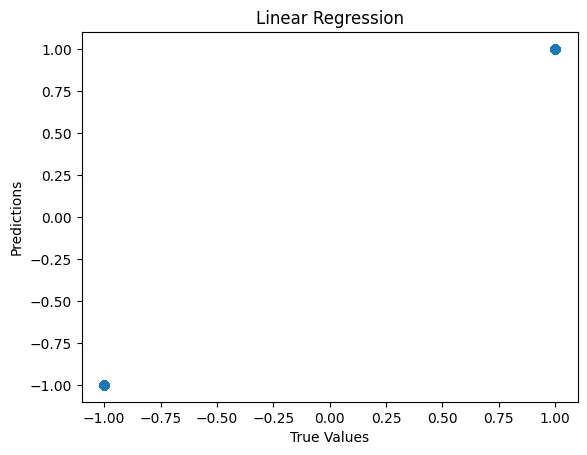

In [13]:
# visualizing the results
plot_predictions(y_test, lr_y_pred, 'Linear Regression', 'OrderHeader_PurchasingOrderQuantity' ,'lr')

In [14]:
# dataframe with the predictions and the actual values, plus other metrics
lr_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_y_pred})
lr_results['Difference'] = lr_results['Actual'] - lr_results['Predicted']
lr_results['Absolute Difference'] = np.abs(lr_results['Difference'])
lr_results['Squared Difference'] = lr_results['Difference'] ** 2

lr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
5343,1,1.0,2.220446e-16,2.220446e-16,4.930381e-32
56204,1,1.0,5.551115e-16,5.551115e-16,3.081488e-31
63371,1,1.0,-2.220446e-16,2.220446e-16,4.930381e-32
63159,1,1.0,0.000000e+00,0.000000e+00,0.000000e+00
11257,1,1.0,-2.220446e-16,2.220446e-16,4.930381e-32
...,...,...,...,...,...
56881,1,1.0,2.442491e-15,2.442491e-15,5.965761e-30
12912,1,1.0,1.110223e-16,1.110223e-16,1.232595e-32
34739,1,1.0,5.551115e-16,5.551115e-16,3.081488e-31
56267,1,1.0,1.887379e-15,1.887379e-15,3.562200e-30


In [15]:
# printing the average absolute difference
print(f'Average Absolute Difference: {lr_results["Absolute Difference"].mean()}')

Average Absolute Difference: 1.4897956224134533e-15


C:\Users\Tjorn\PycharmProjects\United-Outdoors\visualization\static\training\prediction\OrderHeader_PurchasingOrderQuantity\lr_feature_importance.png


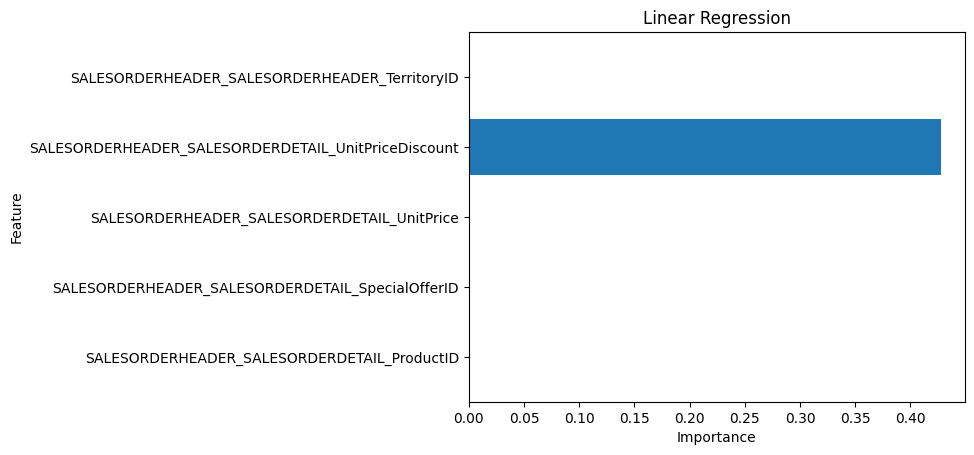

In [16]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, lr_model.coef_, 'Linear Regression','OrderHeader_PurchasingOrderQuantity' ,'lr')

### Decision Tree Regressor

In [17]:
# fitting the model
dtr_model = DecisionTreeRegressor(max_depth=5)

dtr_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=5)

In [18]:
# predicting the values
dtr_y_pred = dtr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [19]:
# calculating the metrics
dtr_mse = mean_squared_error(y_test, dtr_y_pred)
dtr_r2 = r2_score(y_test, dtr_y_pred)
print(f'Mean Squared Error: {dtr_mse}')
print(f'R2 Score: {dtr_r2}')

Mean Squared Error: 0.0
R2 Score: 1.0


C:\Users\Tjorn\PycharmProjects\United-Outdoors\visualization\static\training\prediction\OrderHeader_PurchasingOrderQuantity\dt.png


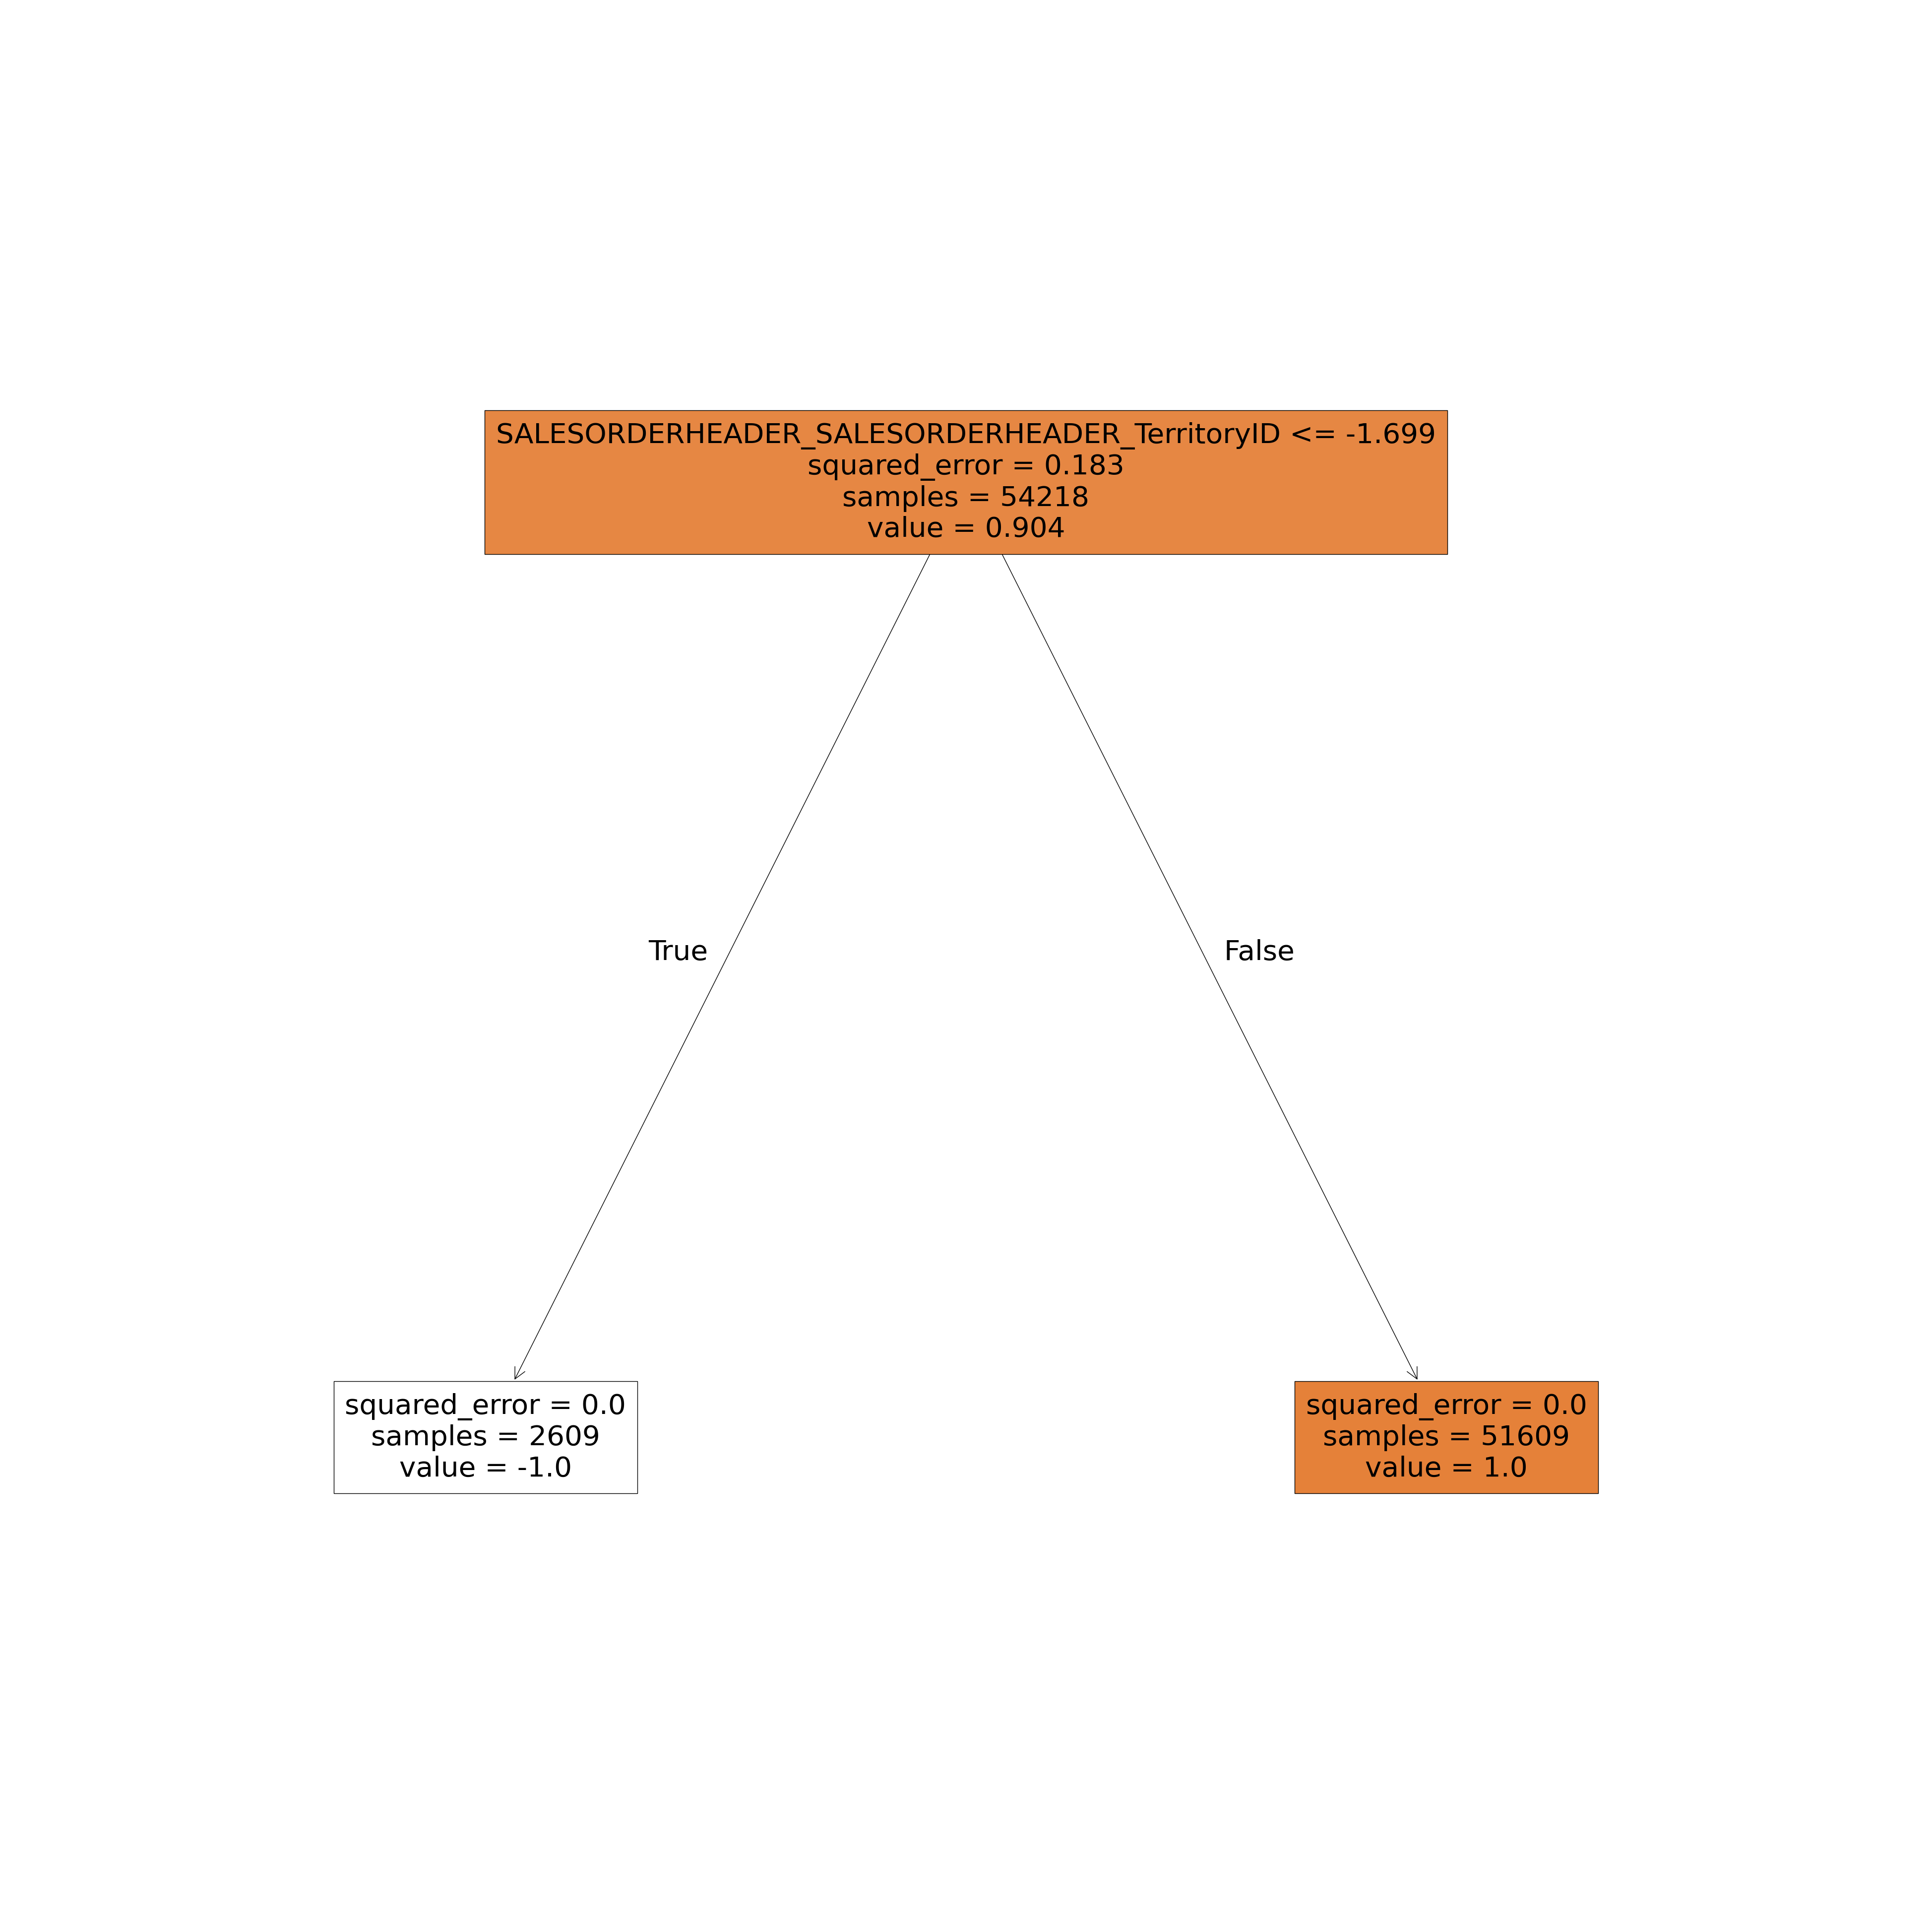

In [20]:
# visualizing the decision tree
plot_decision_tree(dtr_model, X.columns, 'Desicion Tree' , 'OrderHeader_PurchasingOrderQuantity', 'dt')

In [21]:
# dataframe with the predictions and the actual values, plus other metrics
dtr_results = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_y_pred})
dtr_results['Difference'] = dtr_results['Actual'] - dtr_results['Predicted']
dtr_results['Absolute Difference'] = np.abs(dtr_results['Difference'])
dtr_results['Squared Difference'] = dtr_results['Difference'] ** 2

dtr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
5343,1,1.0,0.0,0.0,0.0
56204,1,1.0,0.0,0.0,0.0
63371,1,1.0,0.0,0.0,0.0
63159,1,1.0,0.0,0.0,0.0
11257,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...
56881,1,1.0,0.0,0.0,0.0
12912,1,1.0,0.0,0.0,0.0
34739,1,1.0,0.0,0.0,0.0
56267,1,1.0,0.0,0.0,0.0


In [22]:
# printing the average absolute difference
print(f'Average Absolute Difference: {dtr_results["Absolute Difference"].mean()}')

Average Absolute Difference: 0.0


C:\Users\Tjorn\PycharmProjects\United-Outdoors\visualization\static\training\prediction\OrderHeader_PurchasingOrderQuantity\dt_feature_importance.png


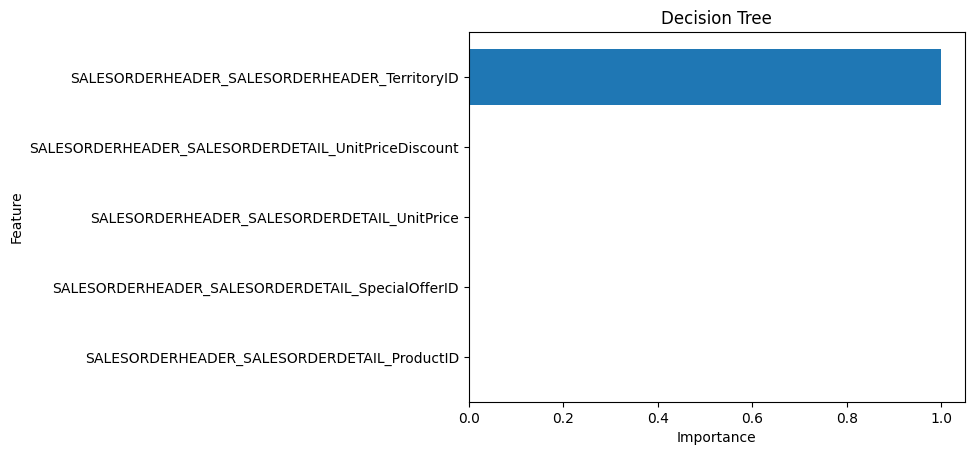

In [23]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, dtr_model.feature_importances_, 'Decision Tree','OrderHeader_PurchasingOrderQuantity' ,'dt')

### Random Forest

In [24]:
# fitting the model
rf_model = RandomForestRegressor(n_estimators=100)

rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [25]:
# predicting the values
rf_y_pred = rf_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [26]:
# calculating the metrics
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)
print(f'Mean Squared Error: {rf_mse}')
print(f'R2 Score: {rf_r2}')

Mean Squared Error: 0.0
R2 Score: 1.0


C:\Users\Tjorn\PycharmProjects\United-Outdoors\visualization\static\training\prediction\OrderHeader_PurchasingOrderQuantity\rf_scatter.png


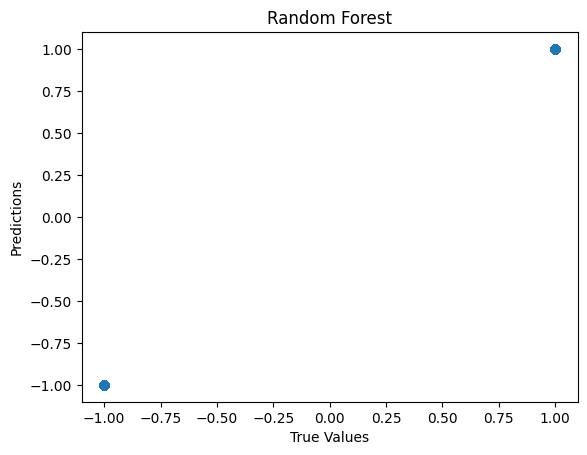

In [27]:
# plotting the results
plot_predictions(y_test, rf_y_pred, 'Random Forest', 'OrderHeader_PurchasingOrderQuantity' ,'rf')

In [28]:
# dataframe with the predictions and the actual values, plus other metrics
rf_results = pd.DataFrame({'Actual': y_test, 'Predicted': rf_y_pred})
rf_results['Difference'] = rf_results['Actual'] - rf_results['Predicted']
rf_results['Absolute Difference'] = np.abs(rf_results['Difference'])
rf_results['Squared Difference'] = rf_results['Difference'] ** 2

rf_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
5343,1,1.0,0.0,0.0,0.0
56204,1,1.0,0.0,0.0,0.0
63371,1,1.0,0.0,0.0,0.0
63159,1,1.0,0.0,0.0,0.0
11257,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...
56881,1,1.0,0.0,0.0,0.0
12912,1,1.0,0.0,0.0,0.0
34739,1,1.0,0.0,0.0,0.0
56267,1,1.0,0.0,0.0,0.0


In [29]:
# printing the average absolute difference
print(f'Average Absolute Difference: {rf_results["Absolute Difference"].mean()}')

Average Absolute Difference: 0.0


C:\Users\Tjorn\PycharmProjects\United-Outdoors\visualization\static\training\prediction\OrderHeader_PurchasingOrderQuantity\rf_feature_importance.png


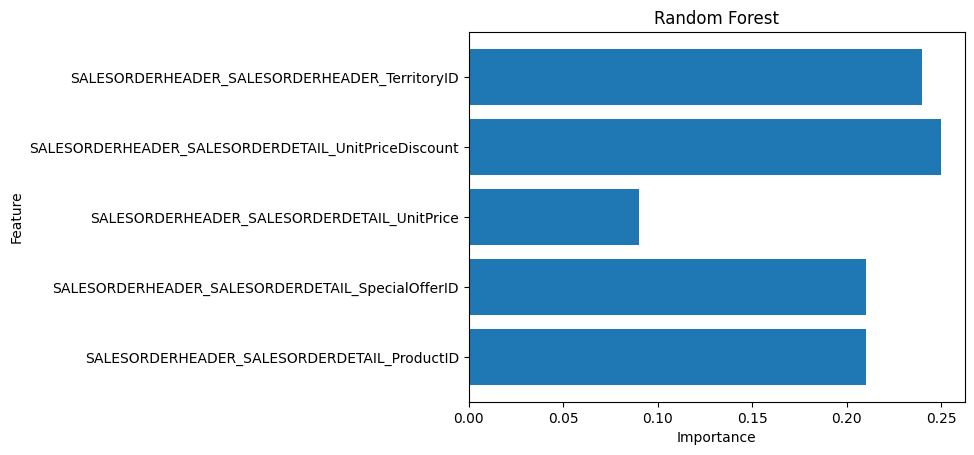

In [30]:
# plotting the feature importances, which means how much each column contributes to the predictions
plot_feature_importance(X.columns, rf_model.feature_importances_, 'Random Forest', 'OrderHeader_PurchasingOrderQuantity' ,'rf')

### Gradient Boosting

In [31]:
# fitting the model
gb_model = GradientBoostingRegressor(n_estimators=100)

gb_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor()

In [32]:
# predicting the values
gb_y_pred = gb_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [33]:
# calculating the metrics
gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_r2 = r2_score(y_test, gb_y_pred)
print(f'Mean Squared Error: {gb_mse}')
print(f'R2 Score: {gb_r2}')

Mean Squared Error: 1.2864702537273218e-10
R2 Score: 0.9999999992944912


C:\Users\Tjorn\PycharmProjects\United-Outdoors\visualization\static\training\prediction\OrderHeader_PurchasingOrderQuantity\gb_scatter.png


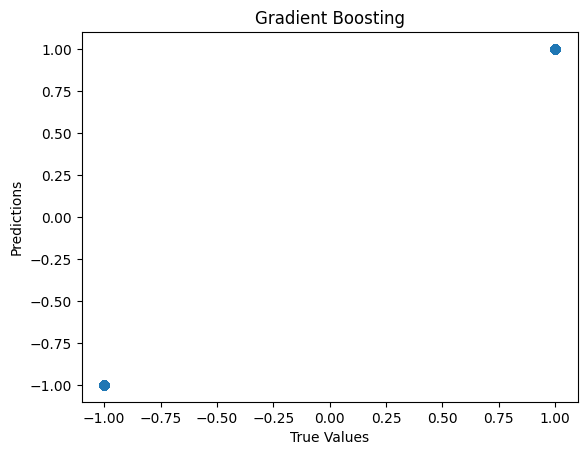

In [34]:
# plotting the results
plot_predictions(y_test, gb_y_pred, 'Gradient Boosting', 'OrderHeader_PurchasingOrderQuantity' ,'gb')

In [35]:
# dataframe with the predictions and the actual values, plus other metrics
gb_results = pd.DataFrame({'Actual': y_test, 'Predicted': gb_y_pred})
gb_results['Difference'] = gb_results['Actual'] - gb_results['Predicted']
gb_results['Absolute Difference'] = np.abs(gb_results['Difference'])
gb_results['Squared Difference'] = gb_results['Difference'] ** 2

gb_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
5343,1,0.999997,0.000003,0.000003,6.534661e-12
56204,1,0.999997,0.000003,0.000003,6.534661e-12
63371,1,0.999997,0.000003,0.000003,6.534661e-12
63159,1,0.999997,0.000003,0.000003,6.534661e-12
11257,1,0.999997,0.000003,0.000003,6.534661e-12
...,...,...,...,...,...
56881,1,0.999997,0.000003,0.000003,6.534661e-12
12912,1,0.999997,0.000003,0.000003,6.534661e-12
34739,1,0.999997,0.000003,0.000003,6.534661e-12
56267,1,0.999997,0.000003,0.000003,6.534661e-12


In [36]:
# printing the average absolute difference
print(f'Average Absolute Difference: {gb_results["Absolute Difference"].mean()}')

Average Absolute Difference: 4.8549792404790015e-06


C:\Users\Tjorn\PycharmProjects\United-Outdoors\visualization\static\training\prediction\OrderHeader_PurchasingOrderQuantity\gb_feature_importance.png


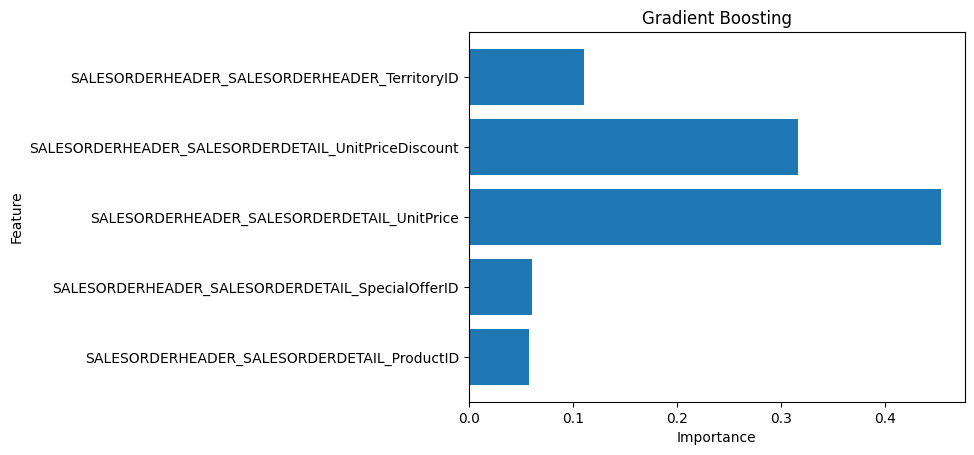

In [37]:
# plotting the feature importances, which means how much each column contributes to the predictions
plot_feature_importance(X.columns, gb_model.feature_importances_, 'Gradient Boosting','OrderHeader_PurchasingOrderQuantity' ,'gb')

### Pytorch Neural Network

In [38]:
# check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# converting the scaled data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)  # target variable often doesn't need scaling
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

Using device: cuda


In [39]:
# instantiate the model
p_model = torch.nn.Sequential(
    torch.nn.Linear(X_train_tensor.shape[1], 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
).to(device)

# define the loss function and the optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(p_model.parameters(), lr=0.01)

# Create TensorDatasets for training and test data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and test data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Train the model
train_model(p_model, criterion, optimizer, train_loader, num_epochs=50)

Epoch 0, Loss: 5.96628569837776e-06


#### Calculating the metrics and visualizing the results

In [40]:
# Evaluate the model
p_model.eval()
p_mse_list = []
p_r2_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = p_model(inputs)
        mse = mean_squared_error(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        p_mse_list.append(mse)
        
        # Only calculate R^2 score if there are more than one samples
        if len(targets) > 1:
            r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
            p_r2_list.append(r2)

# Calculate the average metrics
p_avg_mse = np.mean(p_mse_list)
p_avg_r2 = np.mean(p_r2_list) if p_r2_list else None

print(f'Average Mean Squared Error: {p_avg_mse}')
print(f'Average R2 Score: {p_avg_r2}')

Average Mean Squared Error: 0.0
Average R2 Score: 1.0


In [41]:
# dataframe with the predictions and the actual values, plus other metrics
p_results = pd.DataFrame({'Actual': y_test_tensor.cpu().detach().numpy(), 'Predicted': p_model(X_test_tensor).cpu().detach().numpy().flatten()})
p_results['Difference'] = p_results['Actual'] - p_results['Predicted']
p_results['Absolute Difference'] = np.abs(p_results['Difference'])
p_results['Squared Difference'] = p_results['Difference'] ** 2

p_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
0,1.0,1.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
13550,1.0,1.0,0.0,0.0,0.0
13551,1.0,1.0,0.0,0.0,0.0
13552,1.0,1.0,0.0,0.0,0.0
13553,1.0,1.0,0.0,0.0,0.0


In [42]:
# printing the average absolute difference
print(f'Average Absolute Difference: {p_results["Absolute Difference"].mean()}')

Average Absolute Difference: 0.0


C:\Users\Tjorn\PycharmProjects\United-Outdoors\visualization\static\training\prediction\OrderHeader_PurchasingOrderQuantity\torch_scatter.png


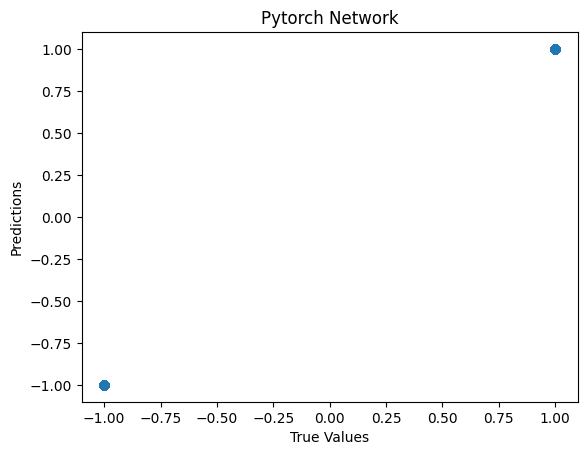

In [43]:
# plotting the feature results
plot_predictions(y_test_tensor.cpu().detach().numpy(), p_model(X_test_tensor).cpu().detach().numpy().flatten(), 'Pytorch Network', 'OrderHeader_PurchasingOrderQuantity' ,'torch')